<a href="https://colab.research.google.com/github/roggersanguzu/tomato-disease-detector/blob/main/AI_Based_Tomato_Health_Monitoring_For_Farmers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install & Import Required Libraries

In [24]:
!pip install -q tensorflow scikit-learn matplotlib seaborn

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


In [26]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Tomato Health'
class_folders = ['blightTomatoes', 'healthyTomatoes', 'mosaicTomatoes', 'saptoriaTomatoes']


 Check for Corrupt Images

In [27]:
from PIL import Image
from tqdm import tqdm

def check_images(folder_path):
    print(" Verifying image integrity...")
    bad_files = []
    for label in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, label)
        for file in tqdm(os.listdir(class_dir), desc=f"Checking {label}"):
            try:
                img_path = os.path.join(class_dir, file)
                img = Image.open(img_path)
                img.verify()
            except Exception:
                bad_files.append(img_path)

    print(f"Found {len(bad_files)} corrupted files.")
    return bad_files

bad_images = check_images(base_dir)
for bad in bad_images:
    os.remove(bad)


 Verifying image integrity...


Checking healthyTomatoes: 100%|██████████| 243/243 [00:05<00:00, 44.62it/s] 

Found 0 corrupted files.


Data Augmentation & Split (80/20)

In [28]:
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 835 images belonging to 4 classes.
Found 208 images belonging to 4 classes.


Compute Class Weights (Important for Mosaic Emphasis)

In [29]:
y_train = train_generator.classes
class_weights = dict(zip(
    np.unique(y_train),
    compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
))

print("Class Weights:", class_weights)


Class Weights: {np.int32(0): np.float64(1.3046875), np.int32(1): np.float64(2.0266990291262137), np.int32(2): np.float64(1.2136627906976745), np.int32(3): np.float64(0.521875)}


Build Transfer Learning Model (MobileNetV2)

In [30]:
# Load pre-trained MobileNetV2 without top
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the Model with Checkpoints

In [31]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3077 - loss: 1.6541
Epoch 1: val_accuracy improved from -inf to 0.63942, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.3119 - loss: 1.6423 - val_accuracy: 0.6394 - val_loss: 0.8376
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6266 - loss: 0.8700
Epoch 2: val_accuracy improved from 0.63942 to 0.73077, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.6276 - loss: 0.8672 - val_accuracy: 0.7308 - val_loss: 0.6511
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7214 - loss: 0.6554
Epoch 3: val_accuracy improved from 0.73077 to 0.77404, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7216 - loss: 0.6548 - val_accuracy: 0.7740 - val_loss: 0.6018
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7740 - loss: 0.5208
Epoch 4: val_accuracy did not improve from 0.77404
27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7740 - loss: 0.5216 - val_accuracy: 0.7692 - val_loss: 0.5858
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7775 - loss: 0.5801
Epoch 5: val_accuracy improved from 0.77404 to 0.82212, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.7785 - loss: 0.5779 - val_accuracy: 0.8221 - val_loss: 0.5306
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8268 - loss: 0.4010
Epoch 6: val_accuracy did not improve from 0.82212
27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.8267 - loss: 0.4023 - val_accuracy: 0.8173 - val_loss: 0.5046
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8502 - loss: 0.4117
Epoch 7: val_accuracy did not improve from 0.82212
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8500 - loss: 0.4120 - val_accuracy: 0.8077 - val_loss: 0.4843
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8435 - loss: 0.3817
Epoch 8: val_accuracy improved from 0.82212 to 0.84135, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8438 - loss: 0.3817 - val_accuracy: 0.8413 - val_loss: 0.4757
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8578 - loss: 0.3487
Epoch 9: val_accuracy did not improve from 0.84135
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8577 - loss: 0.3493 - val_accuracy: 0.7981 - val_loss: 0.5012
Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8387 - loss: 0.3750
Epoch 10: val_accuracy did not improve from 0.84135
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8395 - loss: 0.3743 - val_accuracy: 0.8221 - val_loss: 0.4616
Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8756 - loss: 0.3413
Epoch 11: val_accuracy improved from 0.84135 to 0.84615, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8757 - loss: 0.3413 - val_accuracy: 0.8462 - val_loss: 0.4461
Epoch 12/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8481 - loss: 0.3812
Epoch 12: val_accuracy did not improve from 0.84615
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8489 - loss: 0.3797 - val_accuracy: 0.8269 - val_loss: 0.4373
Epoch 13/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8763 - loss: 0.3140
Epoch 13: val_accuracy improved from 0.84615 to 0.85096, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8767 - loss: 0.3136 - val_accuracy: 0.8510 - val_loss: 0.4551
Epoch 14/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8596 - loss: 0.3603
Epoch 14: val_accuracy did not improve from 0.85096
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8604 - loss: 0.3583 - val_accuracy: 0.8221 - val_loss: 0.4384
Epoch 15/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8732 - loss: 0.3247
Epoch 15: val_accuracy did not improve from 0.85096
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8736 - loss: 0.3236 - val_accuracy: 0.8173 - val_loss: 0.4638
Epoch 16/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8949 - loss: 0.2723
Epoch 16: val_accuracy did not improve from 0.85096
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8946 - loss: 0.2724 - val_accuracy: 0.8413 - val_loss: 0.4597
Epoch 17/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9198 - loss: 0.2281
Epoch 17: val_accuracy improved from 0.85096 to 

27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9194 - loss: 0.2286 - val_accuracy: 0.8702 - val_loss: 0.4228
Epoch 18/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9126 - loss: 0.2570
Epoch 18: val_accuracy did not improve from 0.87019
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9123 - loss: 0.2569 - val_accuracy: 0.8462 - val_loss: 0.4016
Epoch 19/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9149 - loss: 0.2635
Epoch 19: val_accuracy did not improve from 0.87019
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9147 - loss: 0.2630 - val_accuracy: 0.8413 - val_loss: 0.4228
Epoch 20/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8866 - loss: 0.2435
Epoch 20: val_accuracy did not improve from 0.87019
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8869 - loss: 0.2440 - val_accuracy: 0.8413 - val_loss: 0.4565
Epoch 21/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8900 - loss: 0.2573
Epoch 21: val_accuracy did not improve from 0.87

Visualize Training Performance

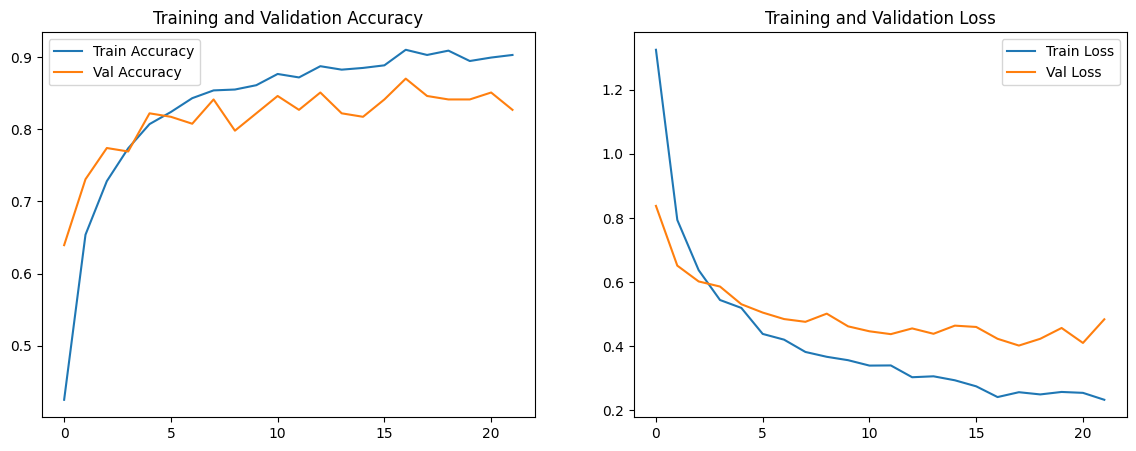

In [38]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


Evaluation – Report & Confusion Matrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
Classification Report:

                  precision    recall  f1-score   support

  blightTomatoes       0.74      0.70      0.72        40
 healthyTomatoes       0.79      0.76      0.78        25
  mosaicTomatoes       0.79      0.79      0.79        43
septoriaTomatoes       0.88      0.91      0.90       100

        accuracy                           0.83       208
       macro avg       0.80      0.79      0.80       208
    weighted avg       0.83      0.83      0.83       208



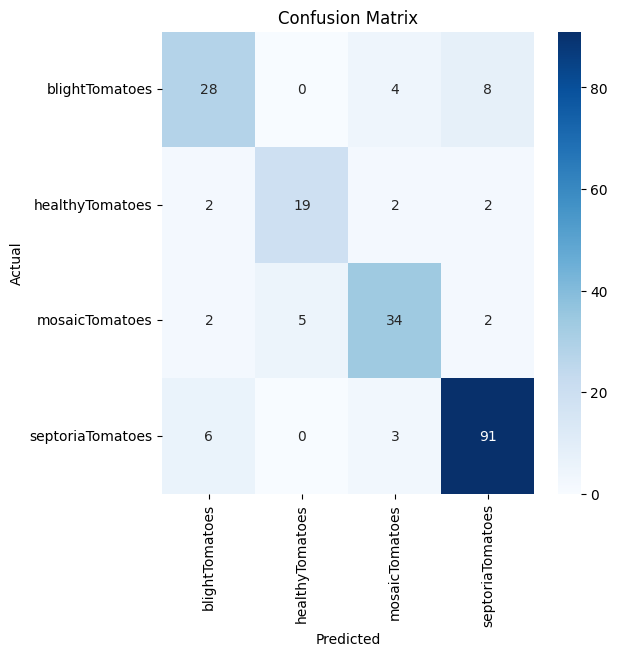

In [40]:
val_generator.reset()
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Save Your Model

In [41]:
# Save final model to Google Drive
model.save('/content/drive/MyDrive/tomato_disease_model_final.h5')
print("Model saved!")


Model saved!


Deploy with Gradio (fastest, cleanest for demo/testing)

In [42]:
!pip install gradio --quiet
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Load trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/tomato_disease_model_final.h5')

# Define class labels
class_names = ['blightTomatoes', 'healthyTomatoes', 'mosaicTomatoes', 'saptoriaTomatoes']

# Define prediction function
def predict_image(img):
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = img_array[np.newaxis, ...]  # Add batch dimension

    preds = model.predict(img_array)
    pred_label = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    return {label: float(prob) for label, prob in zip(class_names, preds[0])}


In [44]:
gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=4),
    title="🍅 Tomato Disease Classifier",
    description="Upload an image of a tomato leaf to detect if it's healthy or has mosaic, blight, or septoria."
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d5cfd23ebb26072cf2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [53]:
!mkdir -p tomato-disease-detector/model
model.save('/content/tomato-disease-detector/model/tomato_model.h5')

!zip -r tomato-disease-detector.zip tomato-disease-detector


updating: tomato-disease-detector/ (stored 0%)
updating: tomato-disease-detector/model/ (stored 0%)
updating: tomato-disease-detector/model/tomato_model.h5 (deflated 12%)


In [54]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

model = tf.keras.models.load_model("/content/tomato-disease-detector/model/tomato_model.h5")
class_names = ['blightTomatoes', 'healthyTomatoes', 'mosaicTomatoes', 'saptoriaTomatoes']

def predict(img):
    img = img.resize((224, 224))
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
    preds = model.predict(img_array)[0]
    return {label: float(preds[i]) for i, label in enumerate(class_names)}

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=4),
    title="🍅 Tomato Disease Detector",
    description="Upload an image of a tomato leaf and get disease predictions."
)

if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d6a57282908910462b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
